In [ ]:
%time
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


%time
n_events = 1000

# dados em 30^o
angle = np.pi/6
rotation_matrix = [[np.cos(angle), -np.sin(angle)],[np.sin(angle), np.cos(angle)]]

m_means = [-0.2,0.2]
m_vars = [0.5,0.05]

data_c1 = m_vars*np.random.randn(n_events,2)+m_means
data_c1 = np.inner(data_c1,rotation_matrix)

m_means = [0.2,-0.2]
m_vars = [0.5,0.05]

data_c2 = m_vars*np.random.randn(n_events,2)+m_means
data_c2 = np.inner(data_c2,rotation_matrix)

data = np.append(data_c1, data_c2,axis=0)
trgt = np.append(1*np.ones(data_c1.shape[0]),2*np.ones(data_c2.shape[0]),axis=0)

df1 = pd.DataFrame()
df1['x1'] = data[:,0]
df1['x2'] = data[:,1]
df1['class'] = trgt

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.53 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.53 µs


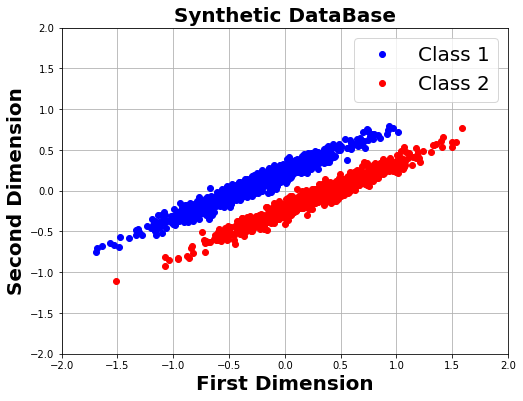

In [ ]:
# plot data
%matplotlib inline  

fig = plt.figure(figsize=(8,6))

plt.plot(df1[df1['class']==1.]['x1'],df1[df1['class']==1.]['x2'],'bo',label='Class 1')
plt.plot(df1[df1['class']==2.]['x1'],df1[df1['class']==2.]['x2'],'ro',label='Class 2')

plt.legend()
plt.grid()
plt.title('Synthetic DataBase',fontweight='bold',fontsize=20)
plt.xlabel('First Dimension',fontweight='bold',fontsize=20)
plt.ylabel('Second Dimension',fontweight='bold',fontsize=20)
limits = [-2, 2]
plt.xlim(limits)
plt.ylim(limits)
plt.legend(fontsize=20)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def calculate_fin(data, predictions, cluster_centers):
    # compute Fi
    n_clusters = np.unique(predictions).shape[0]
    #print(n_clusters)
    class_labels  = np.unique(predictions)
    Fi = np.zeros([n_clusters,1])
    
    for icluster in range(n_clusters):
        if np.sum(predictions==class_labels[icluster]) ==0: continue
        Fi[icluster] = np.sum((data_norm[predictions==class_labels[icluster]] - 
                              cluster_centers[icluster])**2)
    Fin = np.sum(Fi)
    return Fin, Fi

def calculate_fout(data, predictions, cluster_centers):
    # compute center
    bari = np.mean(data,axis=0)
    n_clusters = np.unique(predictions).shape[0]
    class_labels  = np.unique(predictions)
    Fout = 0
    for icluster in range(n_clusters):
        if np.sum(predictions==class_labels[icluster]) ==0: continue
        Fout = Fout + np.sum((cluster_centers[icluster]-bari)**2)
    
    return Fout


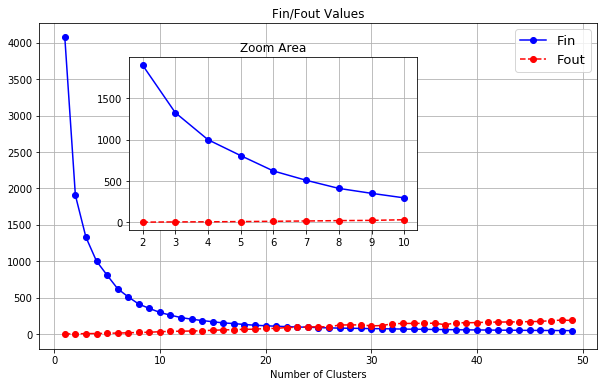

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

nfolds = 10
foldshandler = StratifiedKFold(n_splits=nfolds)

nclusters = list(range(1,50))
Fin = np.zeros([len(nclusters),nfolds])
Fout= np.zeros_like(Fin)

for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt)):
    if ifold != 0: continue
    #print(ifold,trainId, testId)
    data_scaler = StandardScaler().fit(data[trainId])
    data_norm = data_scaler.transform(data)
    #data_norm = data
    
    for icluster in nclusters:
        kmeans = KMeans(n_clusters=icluster, random_state=0).fit(data_norm)
    
        predictions = kmeans.predict(data_norm)
        cluster_centers = kmeans.cluster_centers_
        Fin[icluster-1, ifold], Fi = calculate_fin(data_norm, predictions, cluster_centers)
        Fout[icluster-1, ifold] = calculate_fout(data_norm, predictions, cluster_centers)


fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1)

ax.plot(nclusters,Fin[:,0],'o-',color='blue', label='Fin')
ax.plot(nclusters,Fout[:,0],'o--',color='red', label='Fout')
ax.grid()
ax.set_title('Fin/Fout Analysis')
ax.set_xlabel('Number of Clusters')
ax.set_title('Fin/Fout Values')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc='best', fontsize=13,  markerscale=1., scatterpoints=1,)
rect = [0.2,0.2,0.7,0.7]
ax1 = plt.axes([.25, .4, .4, .4], facecolor='w')
ax1.plot(nclusters[1:10],Fin[1:10,0],'o-',color='blue', label='Fin')
ax1.plot(nclusters[1:10],Fout[1:10,0],'o--',color='red', label='Fout')
ax1.grid()
ax1.set_title('Zoom Area');


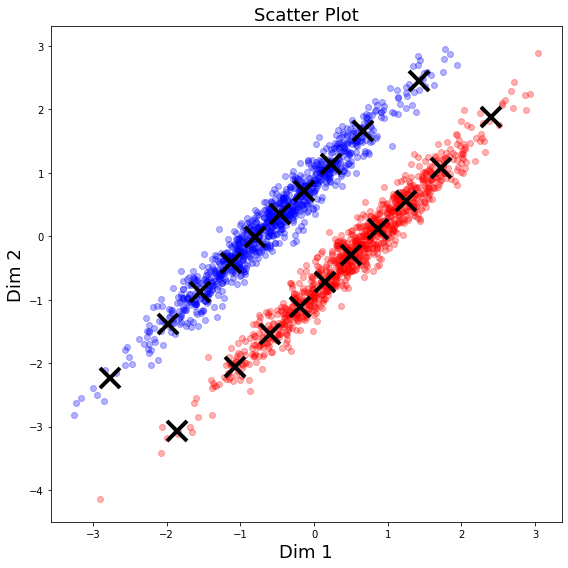

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

m_colors = ['b','r']
font_size = 18

trainId,testId = list(foldshandler.split(data,trgt))[0]
data_scaler = StandardScaler().fit(data[trainId])
data_norm = data_scaler.transform(data)

nclusters = 20
nclasses = np.unique(trgt).shape[0]

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(data_norm)
predicted_data = kmeans.predict(data_norm)
predicted_classes = np.unique(predicted_data)

# painting clusters
mat_cluster_class = np.zeros([nclasses,nclusters])
for idx,iclass in enumerate(np.unique(trgt)):
    for iclus in range(nclusters):
        eff = 100.*(float(np.sum(predicted_data[trgt==iclass]==iclus))
                    /float(np.sum(trgt==iclass)))
        mat_cluster_class[idx,iclus] = eff
# choose most prob class in each cluster
mop_class = np.argmax(mat_cluster_class,axis=0)


fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1, 1, 1)
ax.plot(data_norm[trgt==1,0],data_norm[trgt==1,1],'o',alpha=0.3,color=m_colors[0])
ax.plot(data_norm[trgt==2,0],data_norm[trgt==2,1],'o',alpha=0.3,color=m_colors[1])

for iclus in range(nclusters):
    ax.plot(kmeans.cluster_centers_[iclus][0],
            kmeans.cluster_centers_[iclus][1],
            'x',markeredgecolor='black',#m_colors[mop_class[iclus]],
            markersize=20,mew=4)
            
ax.set_title('Scatter Plot', fontsize=font_size)
ax.set_xlabel('Dim 1',fontsize=font_size)
ax.set_ylabel('Dim 2',fontsize=font_size)
plt.tight_layout()

In [ ]:
pip install kmodes


In [ ]:
import numpy as np
from kmodes.kmodes import KModes

# random categorical data
data = np.random.choice(20, (100, 10))

km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(data)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 25, cost: 803.0
Run 1, iteration: 2/100, moves: 3, cost: 801.0
Run 1, iteration: 3/100, moves: 0, cost: 801.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 23, cost: 791.0
Run 2, iteration: 2/100, moves: 7, cost: 789.0
Run 2, iteration: 3/100, moves: 1, cost: 789.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 16, cost: 804.0
Run 3, iteration: 2/100, moves: 1, cost: 804.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 22, cost: 792.0
Run 4, iteration: 2/100, moves: 5, cost: 791.0
Run 4, iteration: 3/100, moves: 0, cost: 791.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 16, cost: 800.0
Run 5, iteration: 2/100, moves:

#K-Means no Iris


In [ ]:
%%time
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns = iris.feature_names)
y = iris.target

CPU times: user 5.13 ms, sys: 0 ns, total: 5.13 ms
Wall time: 5.17 ms


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.values, y, random_state=0)


In [ ]:
X_train

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
61,5.9,3.0,4.2,1.5
92,5.8,2.6,4.0,1.2
112,6.8,3.0,5.5,2.1
2,4.7,3.2,1.3,0.2
141,6.9,3.1,5.1,2.3
...,...,...,...,...
9,4.9,3.1,1.5,0.1
103,6.3,2.9,5.6,1.8
67,5.8,2.7,4.1,1.0
117,7.7,3.8,6.7,2.2


In [ ]:
#kmeans = KMeans(n_clusters=3, random_state=0).fit(X_train)
#predicted_data_k_means = kmeans.predict(X_test)

In [ ]:
nclusters = list(range(1,10))

In [ ]:
def calculate_fin(data, predictions, cluster_centers):
    # compute Fi
    n_clusters = np.unique(predictions).shape[0]
    #print(n_clusters)
    class_labels  = np.unique(predictions)
    Fi = np.zeros([n_clusters,1])
    
    for icluster in range(n_clusters):
        if np.sum(predictions==class_labels[icluster]) ==0: continue
        Fi[icluster] = np.sum((X_train[predictions==class_labels[icluster]] - 
                              cluster_centers[icluster])**2)
    Fin = np.sum(Fi)
    return Fin, Fi


In [ ]:
Fin =  np.zeros(len(nclusters))


In [ ]:
Fout= np.zeros_like(Fin)
for icluster in nclusters:
  kmeans = KMeans(n_clusters=icluster, random_state=0).fit(X_train)

  predictions = kmeans.predict(X_train)
  cluster_centers = kmeans.cluster_centers_
  Fin[icluster-1], Fi = calculate_fin(X_train, predictions, cluster_centers)
  Fout[icluster-1] = calculate_fout(X_train, predictions, cluster_centers)


Text(0.5, 1.0, 'Fin/Fout Values')

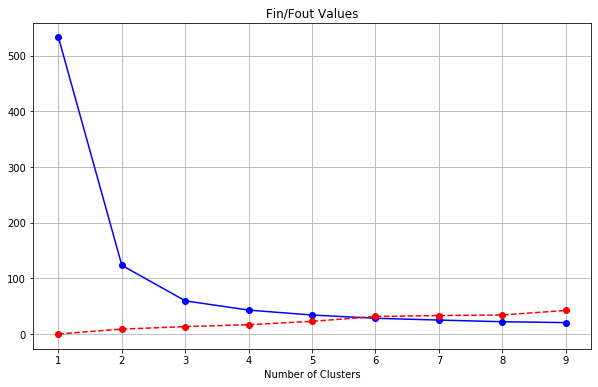

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1, 1, 1)

ax.plot(nclusters,Fin[:],'o-',color='blue', label='Fin')
ax.plot(nclusters,Fout[:],'o--',color='red', label='Fout')
ax.grid()
ax.set_title('Fin/Fout Analysis')
ax.set_xlabel('Number of Clusters')
ax.set_title('Fin/Fout Values')


In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train)
predicted_data_k_means = kmeans.predict(X_test)


In [ ]:
kmeans.cluster_centers_

array([[4.9972973 , 3.38918919, 1.45405405, 0.24054054],
       [6.228     , 2.84      , 4.74      , 1.584     ],
       [7.49090909, 3.14545455, 6.3       , 2.07272727],
       [5.5       , 2.6       , 3.87368421, 1.19473684],
       [6.59      , 3.07      , 5.5       , 2.15      ]])

In [ ]:
decision_tree  = DecisionTreeClassifier()
decision_tree = decision_tree.fit(X_train, y_train)
predicted_data_decision_tree = decision_tree.predict(X_test)

In [ ]:
predicted_data_k_means = np.where(predicted_data_k_means == 3,1,predicted_data_k_means)
predicted_data_k_means = np.where(predicted_data_k_means == 4,2,predicted_data_k_means)

In [ ]:
predicted_data_k_means

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1], dtype=int32)

In [ ]:
predicted_data_decision_tree

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2])

In [ ]:
y_test == 2

array([ True, False, False,  True, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False,  True,  True, False,
       False, False])

In [ ]:
acc_k_means = accuracy_score(y_test, predicted_data_k_means)

In [ ]:
y_test

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1])

In [ ]:
predicted_data_k_means

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1], dtype=int32)

In [ ]:
acc_tree = accuracy_score(y_test, predicted_data_decision_tree)

In [ ]:
results = [acc_k_means,acc_tree]

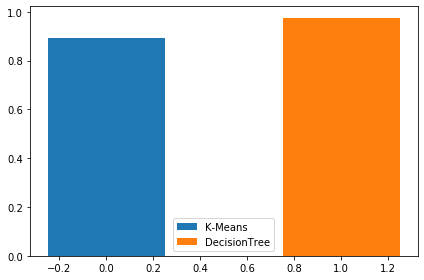

In [ ]:
fig, ax = plt.subplots()
rects1 = ax.bar(0, acc_k_means,0.5, label='K-Means')
rects2 = ax.bar(1, acc_tree, 0.5, label='DecisionTree')
ax.legend()
fig.tight_layout()
plt.show()